# Example - Chicago Crime

<h1>Index<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Create-a-target" data-toc-modified-id="Create-a-target-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Create a target</a></span></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Modeling</a></span><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Data</a></span></li></ul></li><li><span><a href="#Checking-the-support-in-the-different-environments" data-toc-modified-id="Checking-the-support-in-the-different-environments-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Checking the support in the different environments</a></span><ul class="toc-item"><li><span><a href="#Benchmark" data-toc-modified-id="Benchmark-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Benchmark</a></span></li></ul></li><li><span><a href="#Challenger-model" data-toc-modified-id="Challenger-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Challenger model</a></span></li><li><span><a href="#TRF-as-feature-selection" data-toc-modified-id="TRF-as-feature-selection-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>TRF as feature selection</a></span></li><li><span><a href="#Domain-classifier" data-toc-modified-id="Domain-classifier-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Domain classifier</a></span></li></ul></div>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import shap
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from time_robust_forest.models import TimeForestClassifier
from time_robust_forest.functions import check_categoricals_match, check_numerical_match
from models.aux_functions import *

np.random.seed(42)

In [2]:
def set_style():
    plt.style.use(['seaborn-white', 'seaborn-paper'])
    plt.rcParams['figure.figsize'] = (12, 4)

In [3]:
set_style()

In [4]:
DATASETS_PATH = "~/Documents/datasets/olist/"
PREFIX = "olist"

In [5]:
orders = pd.read_csv(DATASETS_PATH + "olist_orders_dataset.csv", engine="python")
customers = pd.read_csv(DATASETS_PATH + "olist_customers_dataset.csv", engine="python")
reviews = pd.read_csv(DATASETS_PATH + "olist_order_reviews_dataset.csv", engine="python")
payments = pd.read_csv(DATASETS_PATH + "olist_order_payments_dataset.csv", engine="python")
products = pd.read_csv(DATASETS_PATH + "olist_products_dataset.csv", engine="python")
category = pd.read_csv(DATASETS_PATH + "product_category_name_translation.csv", engine="python")
items = pd.read_csv(DATASETS_PATH + "olist_order_items_dataset.csv", engine="python")

In [6]:
orders.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')

In [7]:
orders['order_purchase_timestamp'] = pd.to_datetime(orders.order_purchase_timestamp)
orders['order_approved_at'] = pd.to_datetime(orders.order_approved_at).dt.date  
orders['order_estimated_delivery_date'] = pd.to_datetime(orders.order_estimated_delivery_date).dt.date  
orders['order_delivered_customer_date'] = pd.to_datetime(orders.order_delivered_customer_date).dt.date  
items['shipping_limit_date'] = pd.to_datetime(items.shipping_limit_date).dt.date  

In [8]:
data = orders.merge(reviews, on="order_id", how="left")

In [9]:
data = data.merge(items, on="order_id", how="left")
data = data.merge(products, on="product_id", how="left") 

In [10]:
data["Year"] = data["order_purchase_timestamp"].apply(lambda x: int(x.year))
data["Year-month"] = data["order_purchase_timestamp"].apply(lambda x: str(x.year) + "-" + str(x.month).zfill(2))
data["Year-trimester"] = data["order_purchase_timestamp"].apply(lambda x: str(x.year) + "-" + str(int(x.month / 3)).zfill(2))

In [11]:
data.shape

(114100, 31)

In [12]:
data.nunique()

order_id                         99441
customer_id                      99441
order_status                         8
order_purchase_timestamp         98875
order_approved_at                  611
order_delivered_carrier_date     81018
order_delivered_customer_date      645
order_estimated_delivery_date      459
review_id                        99173
review_score                         5
review_comment_title              4600
review_comment_message           36921
review_creation_date               637
review_answer_timestamp          99010
order_item_id                       21
product_id                       32951
seller_id                         3095
shipping_limit_date                555
price                             5968
freight_value                     6999
product_category_name               73
product_name_lenght                 66
product_description_lenght        2960
product_photos_qty                  19
product_weight_g                  2204
product_length_cm        

In [13]:
data.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                        object
order_delivered_carrier_date             object
order_delivered_customer_date            object
order_estimated_delivery_date            object
review_id                                object
review_score                              int64
review_comment_title                     object
review_comment_message                   object
review_creation_date                     object
review_answer_timestamp                  object
order_item_id                           float64
product_id                               object
seller_id                                object
shipping_limit_date                      object
price                                   float64
freight_value                           float64
product_category_name                   

## Create target

In [14]:
data["review_score"].unique()

array([4, 5, 2, 1, 3])

In [15]:
data["target"] = (data["review_score"] == 5).astype(int)

In [16]:
data["target"].mean()

0.5582646801051709

## Modeling

### Data

In [17]:
TIME_COLUMN = "Year-month"
ALTERNATIVE_TIME_COLUMN = "Year-trimester"
TARGET = "target"

In [18]:
data["difference_estimated_delivered"] = (data['order_estimated_delivery_date'] - data['order_delivered_customer_date']).dt.days
data["difference_limit_delivered"] = (data['shipping_limit_date'] - data['order_delivered_customer_date']).dt.days

In [19]:
columns_to_label_encode = ["seller_id",
                           "product_category_name"]

In [20]:
encoder_mappings = {}
le = LabelEncoder()
for column in columns_to_label_encode:
    print(column)
    data[column].fillna("None", inplace=True)
    data[column] = le.fit_transform(data[[column]])
    encoder_mappings[column] = {i: le.__dict__["classes_"][i] for i in range(len(le.__dict__["classes_"]))}

seller_id
product_category_name


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [21]:
numerical_features = ["price",
                      "freight_value",
                      "product_name_lenght",
                      "product_description_lenght", 
                      "product_photos_qty", 
                      "product_weight_g",
                      "product_length_cm",
                      "product_height_cm", 
                      "product_width_cm",
                      "difference_estimated_delivered",
                      "difference_limit_delivered"]

In [22]:
features = columns_to_label_encode + numerical_features
features = list(set(features))

In [23]:
data["Year"].value_counts()

2018    61912
2017    51796
2016      392
Name: Year, dtype: int64

In [24]:
data = data[~data["Year"].isin([2016])]

In [25]:
data["Year"].value_counts()

2018    61912
2017    51796
Name: Year, dtype: int64

In [26]:
training_start_year = 2017
training_end_year = 2017
holdout_end_year = 2018

In [27]:
in_time = data[data["Year"] <= training_end_year]
in_time = in_time[in_time["Year"] >= training_start_year]
out_of_time = data[data["Year"] > training_end_year]

In [28]:
out_of_time = out_of_time[~out_of_time[TIME_COLUMN].isin(["2018-10", "2018-09"])]

In [29]:
train, test = train_test_split(in_time, 
                               test_size=0.2,
                               random_state=42)

In [30]:
train.shape

(41436, 34)

In [31]:
test.shape

(10360, 34)

In [32]:
out_of_time.shape

(61892, 34)

In [33]:
median_input = train.median()
train.fillna(median_input, inplace=True)
test.fillna(median_input, inplace=True)
out_of_time.fillna(median_input, inplace=True)

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Checking the support in the different environments

In [34]:
check_categoricals_match(train, columns_to_label_encode, "Year")

Year
2017    1.0
Name: seller_id, dtype: float64
Year
2017    1.0
Name: product_category_name, dtype: float64


1.0

In [35]:
check_numerical_match(train, numerical_features, TIME_COLUMN, verbose=True, n_q=10)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Year-month
2017-01    0.555556
2017-02    0.555556
2017-03    0.666667
2017-04    0.777778
2017-05    0.666667
2017-06    0.555556
2017-07    0.444444
2017-08    0.555556
2017-09    0.333333
2017-10    0.555556
2017-11    0.555556
2017-12    0.555556
Name: price_quant, dtype: float64
Year-month
2017-01    0.4
2017-02    0.6
2017-03    0.7
2017-04    0.7
2017-05    0.9
2017-06    0.8
2017-07    0.7
2017-08    0.7
2017-09    0.7
2017-10    0.7
2017-11    0.9
2017-12    0.6
Name: freight_value_quant, dtype: float64
Year-month
2017-01    0.8
2017-02    0.8
2017-03    0.9
2017-04    0.8
2017-05    0.9
2017-06    0.8
2017-07    1.0
2017-08    1.0
2017-09    1.0
2017-10    0.9
2017-11    0.9
2017-12    1.0
Name: product_name_lenght_quant, dtype: float64
Year-month
2017-01    1.0
2017-02    1.0
2017-03    1.0
2017-04    1.0
2017-05    1.0
2017-06    1.0
2017-07    1.0
2017-08    1.0
2017-09    1.0
2017-10    1.0
2017-11    1.0
2017-12    1.0
Name: product_description_lenght_quant, dtype: float

0.8224747474747475

### Benchmark

In [36]:
from pycaret.classification import *

In [37]:
TARGET

'target'

In [38]:
clf1 = setup(train[features + [TARGET]], 
             target=TARGET,
             session_id=2, 
             log_experiment=False, 
             experiment_name="{}".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_rf = tune_model(rf,
                     optimize="AUC",
                     fold=5,
                     n_iter=50)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6192,0.6534,0.7282,0.6373,0.6797,0.2153,0.2182
1,0.6266,0.6641,0.7425,0.6413,0.6882,0.2291,0.2330
2,0.6209,0.6557,0.7363,0.6371,0.6831,0.2176,0.2211
3,0.6313,0.6665,0.7359,0.6476,0.6890,0.2408,0.2437
4,0.6306,0.6638,0.7546,0.6423,0.6939,0.2357,0.2406
Mean,0.6257,0.6607,0.7395,0.6411,0.6868,0.2277,0.2313
SD,0.0049,0.0051,0.0088,0.0039,0.0049,0.0099,0.0102


In [39]:
tuned_rf

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=11, max_features='sqrt', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0001,
                       min_impurity_split=None, min_samples_leaf=6,
                       min_samples_split=7, min_weight_fraction_leaf=0.0,
                       n_estimators=250, n_jobs=-1, oob_score=False,
                       random_state=2, verbose=0, warm_start=False)

In [40]:
benchmark_model = tuned_rf
benchmark_model.fit(train[features], train[TARGET])

train["benchmark_prediction_opt"] = benchmark_model.predict_proba(train[features])[:, 1]
test["benchmark_prediction_opt"] = benchmark_model.predict_proba(test[features])[:, 1]
out_of_time["benchmark_prediction_opt"] = benchmark_model.predict_proba(out_of_time[features])[:, 1]

In [41]:
print(roc_auc_score(train[TARGET], train["benchmark_prediction_opt"]))
print(roc_auc_score(test[TARGET], test["benchmark_prediction_opt"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["benchmark_prediction_opt"]))

0.719614981622238
0.6498271430132038
0.6370447470331292


In [42]:
benchmark_model = RandomForestClassifier(n_estimators=100, max_depth=8)
benchmark_model.fit(train[features], train[TARGET])

train["benchmark_prediction"] = benchmark_model.predict_proba(train[features])[:, 1]
test["benchmark_prediction"] = benchmark_model.predict_proba(test[features])[:, 1]
out_of_time["benchmark_prediction"] = benchmark_model.predict_proba(out_of_time[features])[:, 1]

In [43]:
print(roc_auc_score(train[TARGET], train["benchmark_prediction"]))
print(roc_auc_score(test[TARGET], test["benchmark_prediction"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["benchmark_prediction"]))

0.6943819337831764
0.6400774567088006
0.6337837128124693


In [44]:
# benchmark_importances = benchmark_model.feature_importances_
# benchmark_importances = pd.Series(benchmark_importances, index=features)
# benchmark_importances.rename("RF", inplace=True)

In [50]:
results = reverse_learning_curve(train, out_of_time, tuned_rf, features, TARGET, TIME_COLUMN, roc_auc_score, n_rounds=5)

In [51]:
benchmark_importances = results["feature_importance"][-1].copy(deep=True)
benchmark_importances.rename("RF", inplace=True)

product_name_lenght              -0.000117
price                             0.001147
product_height_cm                 0.001687
product_width_cm                  0.001673
product_weight_g                  0.003616
difference_limit_delivered        0.048158
difference_estimated_delivered    0.027543
product_category_name             0.001226
product_photos_qty                0.000579
product_length_cm                 0.000061
freight_value                     0.006986
product_description_lenght        0.000151
seller_id                        -0.000745
Name: RF, dtype: float64

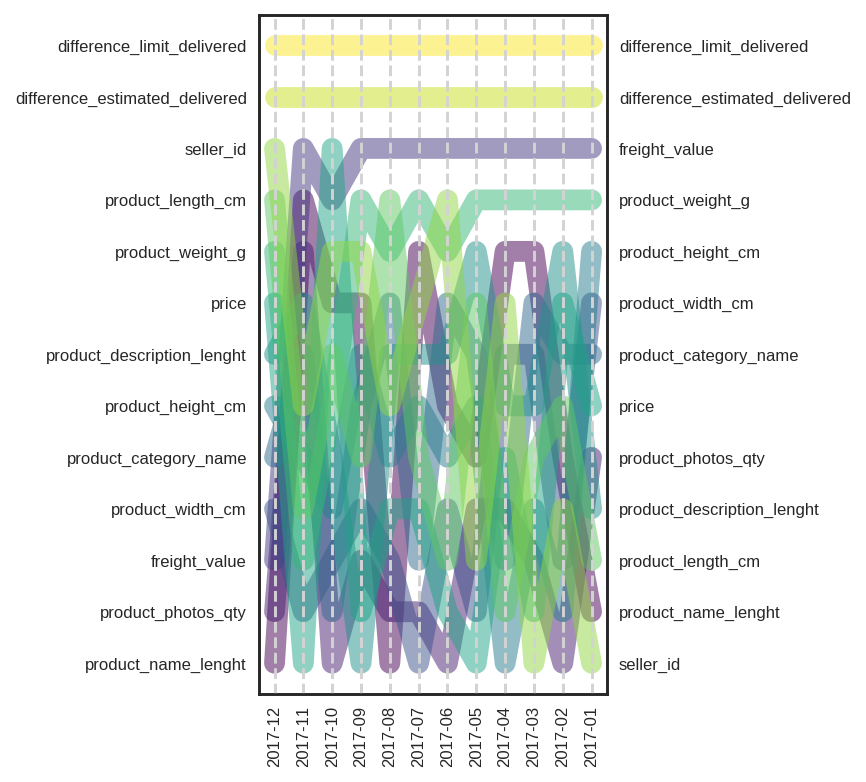

In [52]:
importance_by_reverse_segment_benchmark = plot_feature_migration_from_learning_curve_results(results, features, rotate=True,
                                                                                             save_as="../images/{}_benchmark_importance_migration_learning_curve.eps".format(PREFIX))

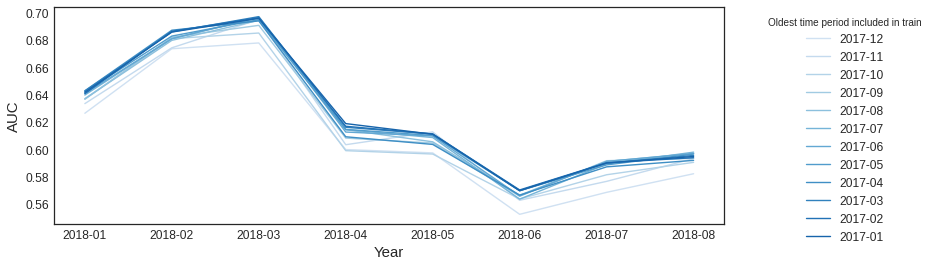

In [48]:
fig, ax = plt.subplots()

blues = plt.get_cmap("Blues")
gradient = np.linspace(.2, 0.8, len(results["holdout_performance"]))

for i, r in enumerate(results["holdout_performance_by_period"]):
    r.plot(label=results["last_period_included"][i], color=blues(gradient[i]))

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Oldest time period included in train")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

plt.savefig("../images/{}_perf_by_period_reverse_learning_curve_benchmark.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

In [49]:
benchmark_importances

product_name_lenght              -0.001706
price                             0.001831
product_height_cm                -0.001167
product_width_cm                 -0.000151
product_weight_g                  0.000417
difference_limit_delivered        0.048189
difference_estimated_delivered    0.022577
product_category_name            -0.000835
product_photos_qty               -0.000938
product_length_cm                 0.001350
freight_value                     0.003356
product_description_lenght        0.000149
seller_id                        -0.001190
Name: RF, dtype: float64

## Challenger model

In [53]:
train.reset_index(drop=True, inplace=True)

In [54]:
train[features + [TIME_COLUMN]]

,product_name_lenght,price,product_height_cm,product_width_cm,product_weight_g,difference_limit_delivered,difference_estimated_delivered,product_category_name,product_photos_qty,product_length_cm,freight_value,product_description_lenght,seller_id,Year-month
0,51.0,267.99,5.0,20.0,350.0,5.0,24.0,45,2.0,20.0,15.63,2025.0,510,2017-08
1,44.0,49.90,21.0,24.0,756.0,-6.0,19.0,13,3.0,32.0,15.70,368.0,1330,2017-02
2,53.0,129.90,30.0,20.0,1000.0,1.0,9.0,54,3.0,20.0,9.72,220.0,1113,2017-08
3,56.0,14.50,4.0,11.0,350.0,-10.0,8.0,71,1.0,19.0,15.10,351.0,1798,2017-06
4,59.0,199.90,15.0,35.0,3800.0,-6.0,15.0,15,2.0,45.0,26.24,302.0,881,2017-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41431,35.0,89.00,2.0,25.0,100.0,7.0,27.0,34,7.0,20.0,17.90,920.0,604,2017-12
41432,30.0,40.00,8.0,11.0,200.0,3.0,11.0,34,2.0,16.0,7.78,227.0,468,2017-06
41433,28.0,213.00,10.0,25.0,1000.0,-4.0,15.0,10,2.0,30.0,18.74,855.0,961,2017-06
41434,54.0,56.99,8.0,21.0,250.0,-1.0,24.0,63,2.0,20.0,14.15,1536.0,2482,2017-11


In [55]:
train["Year"].value_counts()

2017    41436
Name: Year, dtype: int64

In [56]:
train[TIME_COLUMN].nunique()

12

In [57]:
CHALLENGER_MAX_DEPTH = 11
CHALLENGER_N_ESTIMATORS = 250
CHALLENGER_MIN_SAMPLES_BY_PERIODS = 2

In [58]:
challenger_model_max = TimeForestClassifier(time_column=TIME_COLUMN,
                                        n_estimators=CHALLENGER_N_ESTIMATORS,
                                        min_sample_periods=CHALLENGER_MIN_SAMPLES_BY_PERIODS,
                                        max_depth=CHALLENGER_MAX_DEPTH,
                                        period_criterion='max',
                                        multi=True)

challenger_model_max.fit(train[features + [TIME_COLUMN]], train[TARGET].values)

In [59]:
train["challenger_prediction_max"] = challenger_model_max.predict_proba(train[features])[:, 1]
test["challenger_prediction_max"] = challenger_model_max.predict_proba(test[features])[:, 1]
out_of_time["challenger_prediction_max"] = challenger_model_max.predict_proba(out_of_time[features])[:, 1]

In [60]:
print(roc_auc_score(train[TARGET], train["challenger_prediction_max"]))
print(roc_auc_score(test[TARGET], test["challenger_prediction_max"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["challenger_prediction_max"]))

0.6604030398452133
0.6267777404079159
0.6283808427373203


In [61]:
challenger_model_max.feature_importance()

challenger_model_max_importances = challenger_model_max.feature_importance()
challenger_model_max_importances.rename("TRF Max", inplace=True)

freight_value                     2512
product_description_lenght        2495
price                             2494
seller_id                         2265
difference_limit_delivered        2183
product_weight_g                  2084
product_name_lenght               2026
product_length_cm                 2019
product_height_cm                 1884
product_category_name             1830
product_width_cm                  1769
difference_estimated_delivered    1641
product_photos_qty                 864
Name: TRF Max, dtype: int64

In [62]:
challenger_model = TimeForestClassifier(time_column=TIME_COLUMN,
                                        n_estimators=CHALLENGER_N_ESTIMATORS,
                                        min_sample_periods=CHALLENGER_MIN_SAMPLES_BY_PERIODS,
                                        max_depth=CHALLENGER_MAX_DEPTH,
                                        multi=True)
challenger_model.fit(train[features + [TIME_COLUMN]], train[TARGET].values)

train["challenger_prediction"] = challenger_model.predict_proba(train[features])[:, 1]
test["challenger_prediction"] = challenger_model.predict_proba(test[features])[:, 1]
out_of_time["challenger_prediction"] = challenger_model.predict_proba(out_of_time[features])[:, 1]

In [63]:
print(roc_auc_score(train[TARGET], train["challenger_prediction"]))
print(roc_auc_score(test[TARGET], test["challenger_prediction"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["challenger_prediction"]))

0.6588093378341937
0.6258059291032863
0.6263121447059974


## Feature Importance migration

In [ ]:
challenger_model = TimeForestClassifier(time_column=TIME_COLUMN,
                                        n_estimators=CHALLENGER_N_ESTIMATORS,
                                        min_sample_periods=CHALLENGER_MIN_SAMPLES_BY_PERIODS,
                                        max_depth=CHALLENGER_MAX_DEPTH,
                                        multi=True)

results_trt = reverse_learning_curve(train, out_of_time, challenger_model, features, TARGET, TIME_COLUMN, roc_auc_score, n_rounds=5, trt_model=True)

In [ ]:
challenger_model_importances = results_trt["feature_importance"][-1].copy(deep=True)
challenger_model_importances.rename("TRF", inplace=True)

In [ ]:
all_models_importance = pd.DataFrame(index=features)
all_models_importance = all_models_importance.merge(benchmark_importances, how="left", left_index=True, 
                            right_index=True)
all_models_importance = all_models_importance.merge(challenger_model_importances, how="left", left_index=True, 
                            right_index=True)
# all_models_importance = all_models_importance.merge(challenger_model_max_importances, how="left", left_index=True, 
#                             right_index=True)

all_models_importance.fillna(0, inplace=True)
all_models_importance

In [ ]:
plot_shap_difference(all_models_importance[["RF", "TRF"]], title="", save_as="../images/{}_importance_migration.eps".format(PREFIX))

In [ ]:
# plot_shap_difference(all_models_importance, title="", save_as="../images/{}_importance_migration_trf_max.eps".format(PREFIX))

## Reverse Learning Curve

In [ ]:
importance_by_reverse_segment_challenger = plot_feature_migration_from_learning_curve_results(results_trt, features, rotate=True,
                                                                                             save_as="../images/{}_challenger_importance_migration_learning_curve.eps".format(PREFIX))
importance_by_reverse_segment_challenger

In [ ]:
fig, ax = plt.subplots()

greens = plt.get_cmap("Greens")
gradient = np.linspace(.2, 0.8, len(results_trt["holdout_performance"]))

for i, r in enumerate(results_trt["holdout_performance_by_period"]):
    r.plot(label=results_trt["last_period_included"][i], color=greens(gradient[i]))

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Oldest time period included in train")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

plt.savefig("../images/{}_perf_by_period_reverse_learning_curve_challenger.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

In [ ]:
fig, ax = plt.subplots()
plt.plot([str(i) for i in results["sample_size"]], results["holdout_performance"], label="RF")
plt.plot(results_trt["holdout_performance"], label="TRF", linestyle="dashed", color="green")
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("AUC in the holdout", fontsize=15)
plt.xlabel("Sample size", fontsize=15)
plt.savefig("../images/{}_reverse_learning_curve_sample.eps".format(PREFIX), format="eps")
plt.show()

In [ ]:
fig, ax = plt.subplots()
plt.plot([str(i) for i in results["last_period_included"]], results["holdout_performance"], label="RF")
plt.plot(results_trt["holdout_performance"], label="TRF", linestyle="dashed", color="green")
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("AUC in the holdout", fontsize=15)
plt.xlabel("Oldest time period included in the training", fontsize=15)
plt.savefig("../images/{}_reverse_learning_curve_segments.eps".format(PREFIX), format="eps")
plt.show()

In [ ]:
fig, ax = plt.subplots()

greens = plt.get_cmap("Greens")
gradient = np.linspace(.2, 0.8, len(results_trt["holdout_performance"]))

for i, r in enumerate(results_trt["holdout_performance_by_period"]):
    r.plot(label=results_trt["last_period_included"][i], color=greens(gradient[i]))
    
for i, r in enumerate(results["holdout_performance_by_period"]):
    r.plot(label=results["last_period_included"][i], color=blues(gradient[i]))

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Oldest time period included in train")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

plt.savefig("../images/{}_perf_by_period_reverse_learning_curve_both.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

## Performance comparison

In [ ]:
fig, ax = plt.subplots()
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["challenger_prediction"])).plot(label="Time Robust Forest", 
                                                                                                      linestyle="dashed",
                                                                                                      color="green", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt"])).plot(label="Random Forest", ax=ax)

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(12, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
plt.ylim([ymin, ymax])
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)
plt.savefig("../images/{}_test_holdout_auc_years.eps".format(PREFIX), format="eps")
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = (8, 6)
fig, ax = plt.subplots()
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["challenger_prediction"])).plot(label="Time Robust Forest", 
                                                                                                      linestyle="dashed",
                                                                                                      color="green", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt"])).plot(label="Random Forest", ax=ax)


ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

xmin, xmax, ymin, ymax = plt.axis()
#plt.vlines(training_end_year + 1, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
plt.vlines(12, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
plt.ylim([ymin, ymax])
plt.legend(fontsize=13, bbox_to_anchor=(0.12, 1.0))

plt.ylabel("AUC", fontsize=16)
plt.xlabel("Year", fontsize=16)
plt.savefig("../images/{}_test_holdout_auc_years_square.eps".format(PREFIX), format="eps")
plt.show()

## TRF as feature selection

In [ ]:
challenger_model.feature_importance()

In [ ]:
selected_features = [feature for feature in features if feature in challenger_model.feature_importance().index]
selected_features

In [ ]:
if len(selected_features) == len(features):
    selected_features = list(challenger_model.feature_importance().sort_values(ascending=False).index[:int(len(features)/2)+2].values)
    
selected_features    

In [ ]:
selected_features

In [ ]:
clf1 = setup(train[selected_features + [TARGET]], 
             target=TARGET,
             session_id=3, 
             log_experiment=False, 
             experiment_name="{}_fs".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_rf = tune_model(rf,
                     optimize="AUC",
                     fold=5,
                     n_iter=50)

In [ ]:
tuned_rf

In [ ]:
benchmark_model = tuned_rf
benchmark_model.fit(train[selected_features], train[TARGET])

train["benchmark_prediction_opt_selected_features"] = benchmark_model.predict_proba(train[selected_features])[:, 1]
test["benchmark_prediction_opt_selected_features"] = benchmark_model.predict_proba(test[selected_features])[:, 1]
out_of_time["benchmark_prediction_opt_selected_features"] = benchmark_model.predict_proba(out_of_time[selected_features])[:, 1]

In [ ]:
print(roc_auc_score(train[TARGET], train["benchmark_prediction_opt_selected_features"]))
print(roc_auc_score(test[TARGET], test["benchmark_prediction_opt_selected_features"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["benchmark_prediction_opt_selected_features"]))

In [ ]:
train[TIME_COLUMN].nunique()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["challenger_prediction"])).plot(label="Time Robust Forest", 
                                                                                                      linestyle="dashed",
                                                                                                      color="green", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt"])).plot(label="Random Forest", ax=ax)

pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt_selected_features"])).plot(label="Random Forest w/ TRF feature selection", ax=ax)


ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(12, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
plt.ylim([ymin, ymax])
plt.legend(fontsize=10, bbox_to_anchor=(0.52, 0.25))
plt.ylabel("AUC", fontsize=16)
plt.xlabel("Year", fontsize=16)
plt.savefig("../images/{}_test_holdout_auc_years_square_fs.eps".format(PREFIX), format="eps")
plt.show()

## Feature Impact

In [ ]:
from pygam import LinearGAM
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from matplotlib.collections import PolyCollection as p

In [ ]:
fig, ax = plt.subplots()

sns.distplot(out_of_time["challenger_prediction"], label="TRF")
sns.distplot(out_of_time["benchmark_prediction_opt"], label="RF")

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("Density", fontsize=15)
plt.xlabel("Score", fontsize=15)

__file__ = "../images/{}_trf_rf_score_distribution".format(PREFIX)
plt.savefig(__file__+".jpg", quality=95)
for c in ax.findobj(p):
    c.set_zorder(-1)
    c.set_rasterized(True)
ax.set_rasterization_zorder(0)

ax.set_rasterized(True)
plt.savefig(__file__+".eps")        

plt.savefig("../images/{}_trf_rf_score_distribution.eps".format(PREFIX), format="eps")
plt.show()

In [ ]:
ss = StandardScaler()
out_of_time["challenger_prediction_norm"] = ss.fit_transform(out_of_time[["challenger_prediction"]])
out_of_time["benchmark_prediction_norm"] = ss.fit_transform(out_of_time[["benchmark_prediction_opt"]])

In [ ]:
sns.distplot(out_of_time["challenger_prediction_norm"])
sns.distplot(out_of_time["benchmark_prediction_norm"])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(out_of_time[features], 
                                                    out_of_time[["challenger_prediction", 
                                                                 "benchmark_prediction"]],
                                                    test_size=0.6,
                                                    random_state=42)

print(X_train.shape)
print(X_test.shape)

In [ ]:
numerical_features = [feature for feature in features if feature not in columns_to_label_encode]
numerical_features

In [ ]:
p99 = X_train[numerical_features].quantile(.99)
p01 = X_train[numerical_features].quantile(.01)
p005 = X_train.quantile(.005)

X_train[numerical_features] = X_train[numerical_features].where(
    X_train[numerical_features] < p99, other=p99, axis=1)
X_test[numerical_features] = X_test[numerical_features].where(
    X_test[numerical_features] < p99, other=p99, axis=1)

X_train[numerical_features] = X_train[numerical_features].where(
    X_train[numerical_features] > p01, other=p01, axis=1)
X_test[numerical_features] = X_test[numerical_features].where(
    X_test[numerical_features] > p01, other=p01, axis=1)

X_train = X_train.fillna(p005)
X_test = X_test.fillna(p005)

In [ ]:
dtype = ["numerical" if feature not in columns_to_label_encode else "categorical" for feature in features]

gam_challenger = LinearGAM(dtype=dtype).gridsearch(X_train[features].values, y_train["challenger_prediction"].values)
gam_benchmark = LinearGAM(dtype=dtype).gridsearch(X_train[features].values, y_train["benchmark_prediction"].values)

In [ ]:
pred_test = gam_challenger.predict(X_test[features])
print("r2 test (challenger): %f" %r2_score(y_test["challenger_prediction"], pred_test))

pred_test = gam_benchmark.predict(X_test[features])
print("r2 test (benchmark): %f" %r2_score(y_test["benchmark_prediction"], pred_test))

In [ ]:
for i, feat in enumerate(features):
    if feat not in numerical_features:
        continue
    print(feat)
    print(i)
    XX = gam_challenger.generate_X_grid(i, n=X_test.shape[0])
    ### Fix needed for this dataset
    XX[:, 8] = X_test.values[:, 8]
    pdep, confi = gam_challenger.partial_dependence(i, X=XX, width=.95)
    fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

    plt.plot(XX[:, i], pdep, c="green", label="TRF")
    plt.plot(XX[:, i], confi, c='green', ls='--')
    plt.ylabel("Score")
    plt.legend()

    ### Benchmark
    pdep, confi = gam_benchmark.partial_dependence(i, X=XX, width=.95)
    plt.plot(XX[:, i], pdep, color="#4c72b0", label="RF")
    plt.plot(XX[:, i], confi, c='#4c72b0', ls='--')
    plt.ylabel("Score", fontsize=15)
    plt.legend()

    plt.xlabel(feat, fontsize=15)

    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    xmin, xmax, ymin, ymax = plt.axis()
    plt.ylim([ymin, ymax])
    plt.legend(fontsize=15)
    plt.savefig("../images/{}_feature_impact_{}.eps".format(PREFIX, feat), format="eps")

    plt.show()
    plt.clf()

In [ ]:
for i, feat in enumerate(features):
    if feat in columns_to_label_encode:
        print(feat)
        try:
            mapping = encoder_mappings[feat]
            max_cat = np.max(list(mapping.keys()))
            if max_cat > 100:
                continue
            XX = np.copy(X_test)
            XX[:, i] = np.random.randint(0, max_cat, size=X_test.shape[0])
            pdep, confi = gam_challenger.partial_dependence(i, X=XX, width=.95)
            fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
            data = pd.DataFrame(np.hstack([XX[:, i].reshape(-1, 1), pdep.reshape(-1, 1), confi]),
                                columns=[feat, "Mean Impact", "low", "high"])
            data["low"] = np.abs(data["low"] - data["Mean Impact"])
            data["high"] = np.abs(data["high"] - data["Mean Impact"])
            agg = data.groupby(feat).mean()

            impact_plot = plt.bar([i for i in range(len(agg))],
                                  agg["Mean Impact"],
                                  yerr=agg[["low", "high"]].values.transpose(),
                                  color="#9370DB",
                                  capsize=7)

            plt.title(feat, fontsize=15)
            plt.xticks([i for i in range(len(list(mapping.keys())))])
            ax.set_xticklabels(list(mapping.values()), rotation=90)
            plt.hlines(0.0, -1, max_cat, linestyles="dashed")
            plt.ylabel("Score", fontsize=15)

            ax.xaxis.set_tick_params(labelsize=12)
            ax.yaxis.set_tick_params(labelsize=12)
            xmin, xmax, ymin, ymax = plt.axis()
            plt.ylim([ymin, ymax])
            plt.legend(fontsize=15)
            plt.savefig("../images/{}_feature_impact_cat_{}.eps".format(PREFIX, feat), format="eps")

            plt.show()
            plt.clf()
        except:
            print("No plot for {}".format(feat))
plt.show()

In [ ]:
for i, feat in enumerate(features):
    if feat in columns_to_label_encode:
        print(feat)
        mapping = encoder_mappings[feat]
        max_cat = np.max(list(mapping.keys()))
        if max_cat > 100:
            continue
        XX = np.copy(X_test)
        XX[:, i] = np.random.randint(0, max_cat, size=X_test.shape[0])
        ### Challenger
        pdep, confi = gam_challenger.partial_dependence(i, X=XX, width=.95)
        fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
        data = pd.DataFrame(np.hstack([XX[:, i].reshape(-1, 1), pdep.reshape(-1, 1), confi]),
                            columns=[feat, "Mean Impact", "low", "high"])
        data["low"] = np.abs(data["low"] - data["Mean Impact"])
        data["high"] = np.abs(data["high"] - data["Mean Impact"])
        data["model"] = "TRF"
        agg = data.groupby(feat).mean()


        ### Benchmark
        pdep, confi = gam_benchmark.partial_dependence(i, X=XX, width=.95)
        data_benchmark = pd.DataFrame(np.hstack([XX[:, i].reshape(-1, 1), pdep.reshape(-1, 1), confi]),
                            columns=[feat, "Mean Impact", "low", "high"])
        data_benchmark["low"] = np.abs(data_benchmark["low"] - data_benchmark["Mean Impact"])
        data_benchmark["high"] = np.abs(data_benchmark["high"] - data_benchmark["Mean Impact"])
        data_benchmark["model"] = "RF"
        
        data = pd.concat([data, data_benchmark])
        agg = data.groupby(feat).mean()
        
        sns.barplot(data=data, x=feat, y="Mean Impact", hue="model")


        plt.xticks([i for i in range(len(list(mapping.keys())))])
        ax.set_xticklabels(list(mapping.values()), rotation=90)
        plt.hlines(0.0, -1, max_cat, linestyles="dashed")
        plt.ylabel("Score", fontsize=15)
        
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        xmin, xmax, ymin, ymax = plt.axis()
        plt.ylim([ymin, ymax])
        plt.legend(fontsize=15)
        plt.xlabel(feat, fontsize=15)
        plt.savefig("../images/{}_feature_impact_cat_comparison_{}.eps".format(PREFIX, feat), format="eps")
        
        plt.show()
        plt.clf()

## Minimum samples by period effect

In [ ]:
target = TARGET
min_sample_periods_values = [1, 5, 10, 20, 50, 100, 250, 500]

In [ ]:
min_sample_knob = {}
min_sample_knob["challenger"] = {"unseen_performance": [], "train_performance": [],
                                "test_performance": [], "unseen_performance_by_period": []}
unseen_performance = []
train_performance = []
test_performance = []
unseen_performance_by_period = []

for min_sample_periods in min_sample_periods_values:
    model_split_time = TimeForestClassifier(time_column=TIME_COLUMN,
                                        n_estimators=CHALLENGER_N_ESTIMATORS,
                                        min_sample_periods=min_sample_periods,
                                        max_depth=CHALLENGER_MAX_DEPTH,
                                        multi=True)
    
    model_split_time.fit(train[features + [TIME_COLUMN]], train[target])
    out_of_time["time_split_prediction"] = model_split_time.predict_proba(out_of_time[features])[:, 1]
    
    performance = metrics.roc_auc_score(out_of_time[target], out_of_time["time_split_prediction"])
    min_sample_knob["challenger"]["unseen_performance"].append(performance)
    min_sample_knob["challenger"]["unseen_performance_by_period"].append(out_of_time.groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[target], x["time_split_prediction"])))

    train["time_split_prediction"] = model_split_time.predict(train[features])
    min_sample_knob["challenger"]["train_performance"].append(metrics.roc_auc_score(train[target], train["time_split_prediction"]))
    
    test["time_split_prediction"] = model_split_time.predict(test[features])
    min_sample_knob["challenger"]["test_performance"].append(metrics.roc_auc_score(test[target], test["time_split_prediction"]))

In [ ]:
fig, ax = plt.subplots()
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["train_performance"], label="Train")
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["test_performance"], label="Test", 
         color="magenta",
         linestyle="dotted")
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["unseen_performance"], label="Holdout", 
                                                         linestyle="dashed",
                                                         color="green")

#plt.title("Holdout AUC by minimum examples by period parameter", fontsize=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
xmin, xmax, ymin, ymax = plt.axis()
plt.ylim([ymin, ymax])
plt.legend(fontsize=15)
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Minimum examples by period", fontsize=15)
plt.savefig("../images/{}_test_min_example_by_period_train_and_holdout_whole.eps".format(PREFIX), format="eps")
plt.show()

In [ ]:
fig, ax = plt.subplots()

greens = plt.get_cmap("Greens")
gradient = np.linspace(.1, 0.9, len(min_sample_periods_values))
for i, experiment in enumerate(min_sample_knob["challenger"]["unseen_performance_by_period"]):
    experiment.plot(label=min_sample_periods_values[i], color=greens(gradient[i]))

out_of_time.groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[target], x["benchmark_prediction_opt"])).plot(label="Optimal RF benchmark", 
                                                                                                 color="red", linestyle="dashed", ax=ax)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Minimum examples by period")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

x_labels = np.sort(out_of_time[TIME_COLUMN].unique())
#plt.xticks(x_labels)

plt.savefig("../images/{}_holdout_dif_min_samples.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

In [ ]:
min_sample_knob["benchmark"] = {"unseen_performance": [], "train_performance": [],
                                "test_performance": [], "unseen_performance_by_period": []}

training_segments = train[TIME_COLUMN].nunique()
for min_sample_periods in min_sample_periods_values:

    model = tuned_rf
    model.set_params(min_samples_leaf=training_segments * min_sample_periods)
    
    
    model.fit(train[features],
              train[TARGET])
     
    out_of_time["time_split_prediction"] = model.predict_proba(out_of_time[features])[:, 1]
    
    performance = metrics.roc_auc_score(out_of_time[target], out_of_time["time_split_prediction"])
    min_sample_knob["benchmark"]["unseen_performance"].append(performance)
    min_sample_knob["benchmark"]["unseen_performance_by_period"].append(out_of_time.groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[target], x["time_split_prediction"])))

    train["time_split_prediction"] = model.predict(train[features])
    min_sample_knob["benchmark"]["train_performance"].append(metrics.roc_auc_score(train[target], train["time_split_prediction"]))
    
    test["time_split_prediction"] = model.predict(test[features])
    min_sample_knob["benchmark"]["test_performance"].append(metrics.roc_auc_score(test[target], test["time_split_prediction"]))

In [ ]:
fig, ax = plt.subplots()

blues = plt.get_cmap("Blues")
for i, experiment in enumerate(min_sample_knob["benchmark"]["unseen_performance_by_period"]):
    experiment.plot(label=min_sample_periods_values[i], color=blues(gradient[i]))

out_of_time.groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[target], x["benchmark_prediction_opt"])).plot(label="Optimal RF benchmark", 
                                                                                                 color="red", linestyle="dashed", ax=ax)

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Minimum examples by period")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

x_labels = np.sort(out_of_time[TIME_COLUMN].unique())
#plt.xticks(x_labels)

plt.savefig("../images/{}_holdout_dif_min_samples_benchmark.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

In [ ]:
fig, ax = plt.subplots()
for i, experiment in enumerate(min_sample_knob["challenger"]["unseen_performance_by_period"]):
    experiment.plot(label=min_sample_periods_values[i], color=greens(gradient[i]))
    
for i, experiment in enumerate(min_sample_knob["benchmark"]["unseen_performance_by_period"]):
    experiment.plot(label=min_sample_periods_values[i], color=blues(gradient[i]))    

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Minimum examples by period")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

x_labels = np.sort(out_of_time[TIME_COLUMN].unique())
#plt.xticks(x_labels)

plt.savefig("../images/{}_holdout_dif_min_samples_benchmark_challenger.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

In [ ]:
fig, ax = plt.subplots()
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["train_performance"], label="TRF Train",
        color="#4c72b0", linestyle="dashed")
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["test_performance"], label="TRF Test", 
         color="magenta",
         linestyle="dashed")
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["unseen_performance"], label="TRF Holdout", 
                                                         linestyle="dashed",
                                                         color="green")

plt.plot(min_sample_periods_values, min_sample_knob["benchmark"]["train_performance"], label="RF Train",
        color="#4c72b0")
plt.plot(min_sample_periods_values, min_sample_knob["benchmark"]["test_performance"], label="RF Test", 
         color="magenta")
plt.plot(min_sample_periods_values, min_sample_knob["benchmark"]["unseen_performance"], label="RF Holdout", 
                                                         color="green")

#plt.title("Holdout AUC by minimum examples by period parameter", fontsize=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
xmin, xmax, ymin, ymax = plt.axis()
plt.ylim([ymin, ymax])
plt.legend(fontsize=15)
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Minimum examples by period", fontsize=15)
plt.savefig("../images/{}_test_min_example_by_period_train_and_holdout_whole_bench_challenger.eps".format(PREFIX), format="eps")
plt.show()

In [ ]:
fig, ax = plt.subplots()

plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["unseen_performance"], label="TRF Holdout", 
                                                         linestyle="dashed",
                                                         color="green")

plt.plot(min_sample_periods_values, min_sample_knob["benchmark"]["unseen_performance"], label="RF Holdout", 
                                                         color="green")

#plt.title("Holdout AUC by minimum examples by period parameter", fontsize=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
xmin, xmax, ymin, ymax = plt.axis()
plt.ylim([ymin, ymax])
plt.legend(fontsize=15)
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Minimum examples by period", fontsize=15)
plt.savefig("../images/{}_holdout_min_example_by_period_train_and_holdout_whole_bench_challenger.eps".format(PREFIX), format="eps")
plt.show()

## Domain classifier

In [ ]:
train["domain"] = 1
test["domain"] = 1
out_of_time["domain"] = 0

In [ ]:
domain_data = pd.concat([train, test, out_of_time])

In [ ]:
train_domain, test_domain = train_test_split(domain_data, 
                               test_size=0.2,
                               random_state=42)

In [ ]:
clf2 = setup(train_domain[features + ["domain"]], target="domain",
             session_id=124, 
             log_experiment=False, 
             experiment_name="{}_domain".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_domain_rf = tune_model(rf,
                             optimize="AUC",
                             fold=5,
                             n_iter=50)

In [ ]:
domain_model = tuned_domain_rf

In [ ]:
domain_model.fit(train_domain[features], train_domain["domain"])

In [ ]:
test_domain["pred_domain"] = domain_model.predict_proba(test_domain[features])[:, 1]

In [ ]:
roc_auc_score(test_domain["domain"], test_domain["pred_domain"])

## Other optimization design for the RF

In [ ]:
last_time_segment_in_train = np.max(in_time[TIME_COLUMN].unique())
last_time_segment_in_train

In [ ]:
posfix = str(last_time_segment_in_train)

In [ ]:
new_train = in_time[in_time[TIME_COLUMN] < last_time_segment_in_train]
new_validation = in_time[in_time[TIME_COLUMN] == last_time_segment_in_train]

In [ ]:
clf1 = setup(new_train[features + [TARGET]], target=TARGET,
             test_data=new_validation,
             session_id=44,
             log_experiment=False,
             experiment_name="{}_opt1".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_rf = tune_model(rf,
                     optimize="AUC",
                     n_iter=50)

In [ ]:
tuned_rf

In [ ]:
benchmark_model = tuned_rf
benchmark_model.fit(train[features], train[TARGET])

train["benchmark_prediction_opt_{}".format(posfix)] = benchmark_model.predict_proba(train[features])[:, 1]
test["benchmark_prediction_opt_{}".format(posfix)] = benchmark_model.predict_proba(test[features])[:, 1]
out_of_time["benchmark_prediction_opt_{}".format(posfix)] = benchmark_model.predict_proba(out_of_time[features])[:, 1]

In [ ]:
new_validation, add_to_train = train_test_split(new_validation, test_size=0.5)

new_train = pd.concat([new_train, add_to_train])

In [ ]:
clf1 = setup(new_train[features + [TARGET]], target=TARGET,
             test_data=new_validation,
             session_id=22,
             log_experiment=False,
             experiment_name="{}_opt2".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_rf = tune_model(rf,
                     optimize="AUC",
                     n_iter=50)

In [ ]:
benchmark_model = tuned_rf
benchmark_model.fit(train[features], train[TARGET])

train["benchmark_prediction_opt_half_{}".format(posfix)] = benchmark_model.predict_proba(train[features])[:, 1]
test["benchmark_prediction_opt_half_{}".format(posfix)] = benchmark_model.predict_proba(test[features])[:, 1]
out_of_time["benchmark_prediction_opt_half_{}".format(posfix)] = benchmark_model.predict_proba(out_of_time[features])[:, 1]

In [ ]:
fig, ax = plt.subplots()
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["challenger_prediction"])).plot(label="Time Robust Forest", 
                                                                                                      linestyle="dashed",
                                                                                                      color="green", ax=ax)

pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt_half_{}".format(posfix)])).plot(label="RF: Half {} in validation".format(posfix), 
                                                                                                      #linestyle="dashed",
                                                                                                      color="purple", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt"])).plot(label="RF: K-fold in the in-time", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt_{}".format(posfix)])).plot(label="RF: Full {} in validation".format(posfix), ax=ax)

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(12, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
plt.ylim([ymin, ymax])
plt.legend(fontsize=10, bbox_to_anchor=(0.10, 1.0))
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)
plt.savefig("../images/{}_performance_proof.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()
